**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [5]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [6]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [7]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [8]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 [==============================] - 9s 0us/step


Now we can create the callbacks we need and train the model:

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [10]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1397/1407 [============================>.] - ETA: 0s - loss: 4.3223 - accuracy: 0.1637INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 11s 6ms/step - loss: 4.3079 - accuracy: 0.1638 - val_loss: 2.1531 - val_accuracy: 0.2270
Epoch 2/100
1395/1407 [============================>.] - ETA: 0s - loss: 2.0756 - accuracy: 0.2403INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 2.0749 - accuracy: 0.2405 - val_loss: 2.1077 - val_accuracy: 0.2314
Epoch 3/100
1405/1407 [============================>.] - ETA: 0s - loss: 1.9695 - accuracy: 0.2777INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 1.9694 - accuracy: 0.2777 - val_loss: 1.9378 - val_accuracy: 0.2924
Epoch 4/100
1396/1407 [============================>.] - ETA: 0s - loss: 1.8971 - accuracy: 0.3093INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 1.8972 - accuracy: 0.3095 - val_loss: 1.8708 - val_accuracy: 0.3238
Epoch 5/100
1402/1407 [============================>.] - ETA: 0s - loss: 1.8341 - accuracy: 0.3328INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 1.8339 - accuracy: 0.3328 - val_loss: 1.7938 - val_accuracy: 0.3408
Epoch 6/100
1401/1407 [============================>.] - ETA: 0s - loss: 1.7774 - accuracy: 0.3558INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 1.7773 - accuracy: 0.3560 - val_loss: 1.7406 - val_accuracy: 0.3650
Epoch 7/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.7343 - accuracy: 0.3726INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 6ms/step - loss: 1.7343 - accuracy: 0.3726 - val_loss: 1.7364 - val_accuracy: 0.3644
Epoch 8/100
1403/1407 [============================>.] - ETA: 0s - loss: 1.6922 - accuracy: 0.3903INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 5ms/step - loss: 1.6920 - accuracy: 0.3903 - val_loss: 1.6817 - val_accuracy: 0.3932
Epoch 9/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.6580 - accuracy: 0.4027INFO:tensorflow:Assets written to: my_cifar10_model/assets


INFO:tensorflow:Assets written to: my_cifar10_model/assets


1407/1407 [==============================] - 8s 6ms/step - loss: 1.6580 - accuracy: 0.4027 - val_loss: 1.6572 - val_accuracy: 0.4004
Epoch 10/100
1407/1407 [==============================] - 5s 3ms/step - loss: 1.6374 - accuracy: 0.4098 - val_loss: 1.6992 - val_accuracy: 0.3810
Epoch 11/100
1407/1407 [==============================] - 5s 3ms/step - loss: 1.6116 - accuracy: 0.4208 - val_loss: 1.6913 - val_accuracy: 0.3862
Epoch 12/100
 311/1407 [=====>........................] - ETA: 3s - loss: 1.5993 - accuracy: 0.4199

In [125]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4676


[1.5061508417129517, 0.4675999879837036]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [126]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 32s 18ms/step - loss: 2.0374 - accuracy: 0.2525 - val_loss: 1.8766 - val_accuracy: 0.3154
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7874 - accuracy: 0.3542 - val_loss: 1.8784 - val_accuracy: 0.3268
Epoch 3/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.6806 - accuracy: 0.3969 - val_loss: 1.9764 - val_accuracy: 0.3252
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6112 - accuracy: 0.4228 - val_loss: 1.7087 - val_accuracy: 0.3750
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5521 - accuracy: 0.4476 - val_loss: 1.6272 - val_accuracy: 0.4176
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5030 - accuracy: 0.4660 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4559 - accuracy: 0.4812 - val_loss: 1

[1.4236289262771606, 0.5073999762535095]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [127]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1.9385 - accuracy: 0.3046 - val_loss: 1.8175 - val_accuracy: 0.3510
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7241 - accuracy: 0.3869 - val_loss: 1.7677 - val_accuracy: 0.3614
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6272 - accuracy: 0.4263 - val_loss: 1.6878 - val_accuracy: 0.4054
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5643 - accuracy: 0.4492 - val_loss: 1.6589 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5080 - accuracy: 0.4712 - val_loss: 1.5651 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4613 - accuracy: 0.4872 - val_loss: 1.5305 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4174 - accuracy: 0.5077 - val_loss: 1

[1.4607702493667603, 0.5026000142097473]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [128]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 1.8950 - accuracy: 0.3239 - val_loss: 1.7556 - val_accuracy: 0.3812
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6618 - accuracy: 0.4130 - val_loss: 1.6563 - val_accuracy: 0.4114
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5770 - accuracy: 0.4432 - val_loss: 1.6507 - val_accuracy: 0.4232
Epoch 4/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5081 - accuracy: 0.4672 - val_loss: 1.5892 - val_accuracy: 0.4566
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4561 - accuracy: 0.4902 - val_loss: 1.5382 - val_accuracy: 0.4696
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4094 - accuracy: 0.5050 - val_loss: 1.5236 - val_accuracy: 0.4818
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3636 - accuracy: 0.5232 - val_loss: 1

[1.4779616594314575, 0.498199999332428]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [129]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [130]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, tf.keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [131]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [132]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [133]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


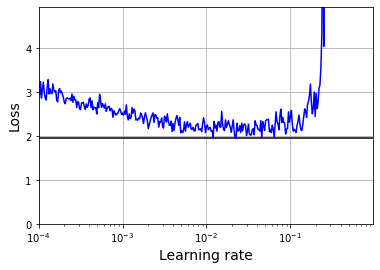

In [134]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [135]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(tf.keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [136]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).